## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Setting the seed to assure, get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("./ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
num_rows = len(df)
num_rows

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean() * 100

11.965919355605511

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
"""     
The number of times the new_page and treatment don't match.
Note: we have two cases
1. group is control and the page is new_page. This will give you 1928 rows.
2. group is treatment and the page is old_page. This will give you 1965 rows.
"""
con_new = len(df.query('group == "control" & landing_page == "new_page"'))
tre_old = len(df.query('group == "treatment" & landing_page == "old_page"'))

In [7]:
con_new + tre_old

3893

f. Do any of the rows have missing values?

In [8]:
df[df.isnull().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

In [9]:
# remove these rows, only use the rows that we can feel confident in the accuracy of the data.
indexes = df.query("group == 'treatment' & landing_page == 'old_page'").append(df.query('group == "control" & landing_page == "new_page"')).index
df2 = df.drop(indexes, axis=0)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
# Since, there is consistency with this id, we can probably just choose either and remove. 
# We shouldn't be counting the same user more than once.
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(['user_id'], inplace=True)

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
(df2.query("group == 'control'")["converted"] == 1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
(df.query("group == 'treatment'")["converted"] == 1).mean()

0.11891957956489856

d. What is the probability that an individual received the new page?

In [18]:
(df['landing_page'] == "new_page").mean()

0.5

By only looking at the statistic, the treatment group's conversion rate is 0.1188, and it is slightly lower than the control group(0.1204). Since the dataset we are using is sample data, it is not sufficient enough. To prove the new treatment page leads to more conversions, we need to use bootstrapping and machine learning to predict the population's parameter. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_old = p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null?

In [20]:
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = len(df2.query("landing_page == 'new_page'"))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = len(df2.query("landing_page == 'old_page'"))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0, 1], size= n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.0020599659978970813

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process our used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000) / n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.

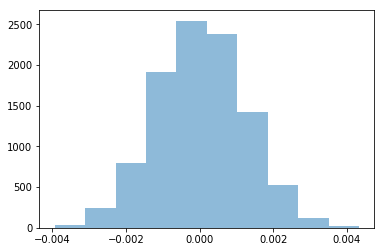

In [28]:
plt.hist(p_diffs, alpha=0.5);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# calculate the actual difference observed in ab_data.csv
control_converted_rate = (df2.query("group == 'control'")["converted"] == 1).mean()
treatment_converted_rate = (df.query("group == 'treatment'")["converted"] == 1).mean()

In [30]:
actual_diff = treatment_converted_rate - control_converted_rate
actual_diff

-0.0014667249355626438

In [31]:
(p_diffs > actual_diff).mean()

0.89300000000000002

k. Please explain what we just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The following are the formulas we stated in question one for the null and alternative hypotheses.

$H_0: p_{new} - p_{old} \leq 0$ <br>
$H_1: p_{new} - p_{old} > 0$

Since the dataset in <b>ab_data.csv</b> is sample data, it is not sufficient to represent the population.

Therefore, to predict the parameter, we used bootstrapping to simulate the sampling distribution of the difference in conversion rate under the $H_0$. Here is the histogram we obtained from part h. For our convenient, a red line of actual difference of conversion rate is included on the graph. 

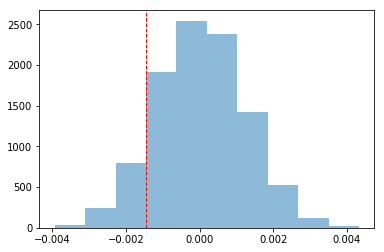

In [32]:
plt.axvline(actual_diff, color='red', linestyle='dashed', linewidth=1)
plt.hist(p_diffs, alpha=0.5);

The calculation we made on part j is the <b>P-value</b> of this hypothesis testing. Graphically, it is the area on the right side of the red vertical line on the above graph.<br>

P-value is the probability of getting our statistic or a more extreme value if the null hypothesis is true. To rephrase it, the larger the P-value, the more favorable our null hypothesis. <br>

In this case, our P-value is 0.8859. Since our Type I error rate is 5%, we have evidence that our statistic was likely to come from the null hypothesis. In other words, we fail to reject the null hypothesis; the new page has no impact on the conversion rate.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = len(df2.query("landing_page == 'old_page' & converted == 1"))
convert_new = len(df2.query("landing_page == 'new_page' & converted == 1"))
n_old = len(df2.query("landing_page == 'old_page'"))
n_new = len(df2.query("landing_page == 'new_page'"))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [35]:
# In the two sample test, smaller: alternative is p1 < p2, larger: p1 > p2 where p1 is the proportion of the first sample and p2 of the second one.
z_score, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

In [36]:
z_score, pval

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score is the distance from the mean. It is positive if the value lies above the mean and negative if it lies below the mean. In this case, we are 1.31 standard deviation below the population mean.<br>

Since the Z-test's P-value is only 0.01 bigger than the one we computed in part k, they agree with the finding (we fail to reject the null hypothesis).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

We use linear regression when predicting quantitative data and logistic regression when predicting categorical data from the previous lessons. Since each row is either a conversion or no conversion, the column is categorical. We should perform <b>logistic regression</b> in this case.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
# create a column for the intercept
df2['intercept'] = 1

# create a dummy variable column for which page each user received.
df2 = df2.join(pd.get_dummies(df2.landing_page)).join(pd.get_dummies(df2.group))

df2.drop(['group', 'landing_page', 'control'], axis=1, inplace=True)
df2.rename(columns={'treatment' : 'ab_page'}, inplace=True)

df2.head()

,user_id,timestamp,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,1,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-11 04:56 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

The p-value associated with ab_page is **0.190**.

In statsmodels, the P-value of the regression model has the following format:

$H_0: \beta_{1} = 0$ <br>
$H_1: \beta_{1} \neq 0$

which is the same as

$H_0: P_{old} = P_{new}$ <br>
$H_1: P_{old} \neq P_{new}$

Since our null and alternative hypotheses are in **Part II** are:

$H_0: p_{new} \leq p_{old}$ <br>
$H_1: p_{new} > p_{old}$

it is apparent that they are different than the value we obtained.

f. Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into our regression model?

It is a good idea to consider other factors to add to our regression model since new factors make our model more comprehensive. Involving more factors into our model, we can determine the relative influence of one or more explanatory variables on the response variable. For instance, in our previous notebook, both the homes' size and the number of bedrooms have a strong correlation to a home's price.

However, using multiple explanatory variables can also result in problems. Problems like correlated error and multi-collinearity might preventing us from getting the real parameter. For example, the explanatory variables like area, bedrooms, and bathrooms are positively correlated when predicting the home prices. These can lead to our coefficients being flipped from the direction we expect.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. we will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows. 

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df_new = df_new.join(pd.get_dummies(df_new.country)[['CA', 'US']]).drop(['country'], axis=1)

model = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])

result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-11 04:58 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

**Does it appear that country had an impact on conversion?**

Recall our null and alternative hypotheses are:

$H_0: P_{old} = P_{new}$ <br>
$H_1: P_{old} \neq P_{new}$

and our $\beta$ (Type I error rate) is 5%. Since the results from **P>|z|** are 0.074 and 0.456, the country column is not statistically significant on conversion. In other words, the impact of country is deficient and we fail to reject the null hypothesis.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [44]:
# we would like to find the interaction between page and country, here is what we can do:
# ab_page treatment:1 control:0, the result simply means the page status in each country
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']

In [45]:
### Fit Your Linear Model And Obtain the Results
model = sm.Logit(df_new['converted'], df_new[['intercept', 'US_ab_page', 'CA_ab_page']])

In [47]:
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-11 04:59 AIC:              212777.1060
No. Observations:   290584           BIC:              212808.8450
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9873    0.0072  -275.5728  0.0000  -2.0014  -1.9732
US_ab_page   -0.0197    0.0121    -1.6337  0.1023  -0.0434   0.0039
CA_ab_page   -0.0842    0.0378    -2.2251  0.0261  -0.1583  -0.0100
==================================================================

"""

As we can see from the result above, the P-value for types of pages in each country does not significantly impact our prediction. Both P-value we obtained from the calculation are greater than our Type I error rate. 

In conclusion, we fail to reject our null hypothesis.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])